# 1. 데이터의 전처리
- 명확한 1회 세션의 session ID를 포함하고 있지 않다. 그래서 UserID가 SessionID의 역할을 해야 한다.
- Rating 정보가 포함되어 있음. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않으므로, 무시하고 제외할 수 있음. -> Rating 3점 이상 반영 후 컬럼 삭제.
- 하지만, 직전에 봤던 영화가 마음에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있음. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 한다.  -> 3점 이상짜리만 반영.
- Time 항목에는 UTC time이 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다. -> timestamp 변환.
- 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행.
- Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 어떻게 Session 단위로 해석할지에 주의.

In [1]:
# Library import
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
batch_size = 3
hsz= 50
drop_rate = 0.1
lr = 0.001
epochs = 3
k= 20

In [3]:
data_path = Path(r'C:/Users/user/Google 드라이브/AIFFEL/Exploration16/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows = None):
    data = pd.read_csv(data_path, sep = '::', header = None, usecols = [0, 1, 2, 3],
                      dtype = {0: np.int32, 1: np.int32, 2: np.int32},
                      nrows = nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data를 id와 시간 순서로 정렬해줍니다.
data.sort_values(['UserId', 'Time'], inplace = True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
data['Time'] = pd.to_datetime(data['Time'], unit= 's')
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


## 1.2 Session Length
- SessionId: 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자. 로그인하지 않았기 때문에 누군지 알 수 없어도 특정 행동 패턴을 SessionId 기준으로 모아서 분류해낼 수 있다.
- Session length: 같은 SessionId를 공유하는 데이터 행의 개수. 해당 세션의 사용자가 그 세션동안 몇 번의 액션을 취했는지(몇 개의 상품 정보를 클릭했는지)의 의미가 된다.

In [5]:
# 추천 시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저 수(세션 수)와 아이템 수이다.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
# 각 세션이 대략 몇 개의 클릭 데이터를 갖는지.
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
# 데이터에서 평점 3점 이상의 것들만 유효데이터로 삼아 필터링.
raw_data_size = len(data)
filtered_data = data[data['Rating'] >= 3]
filtered_data_size = len(data)
print(f'raw_data_size: {raw_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / raw_data_size:.2%}')

raw_data_size: 1000209, filtered_data_size: 1000209
Ratio of Remaining Data is 100.00%


In [8]:
# 필터된 데이터에서 별점 제외하기. 
filtered_data = filtered_data.drop(['Rating'], axis = 1)
filtered_data

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [9]:
# 필터된 데이터에서 각 세션이 대략 몇 개의 시청 데이터를 갖는지.
filtered_session_length = filtered_data.groupby('UserId').size()
filtered_session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [10]:
# 전체 데이터의 중간값과 평균
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [11]:
# 필터된 데이터의 중간값과 평균
filtered_session_length.median(), filtered_session_length.mean()

(81.0, 138.51266766020865)

In [12]:
# 전체 데이터의 최소값과 최대값
session_length.min(), session_length.max()

(20, 2314)

In [13]:
# 필터된 데이터의 최소값과 최대값
filtered_session_length.min(), filtered_session_length.max()

(1, 1968)

In [14]:
# 전체 데이터의 99.9% 순번째의 조회수
session_length.quantile(0.999)

1343.181000000005

In [15]:
# 필터된 데이터의 99.9% 순번째의 조회수
filtered_session_length.quantile(0.999)

1118.8860000000013

In [16]:
# filtered_session_length[filtered_session_length <= 1118].index[0] 

In [17]:
# filtered_long_session = filtered_session_length[filtered_session_length >= 1118].index[1]  # 숫자 및 기준조정
# filtered_data[filtered_data['UserId']==filtered_long_session]

In [18]:
# 세션 길이 기준 하위 99.9% 까지의 분포 누적합을 시각화한 것.
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

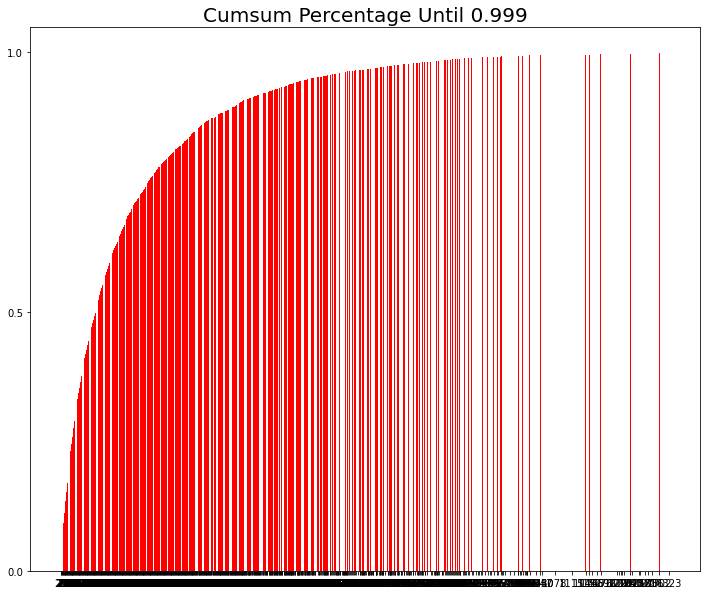

In [19]:
plt.figure(figsize = (12, 10))
plt.bar(x = length_percent_cumsum_999.index,
       height = length_percent_cumsum_999, color = 'red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.5))
plt.title('Cumsum Percentage Until 0.999', size = 20)
plt.show()

## 1.3 Session time

In [20]:
# 데이터의 시간 관련 정보
oldest, latest = filtered_data['Time'].min(), filtered_data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [21]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [22]:
# 최근 360일 간의 데이터만 최근 취향이 반영된, 추천에 유효한 데이터로 가정하였다.
month_ago = latest - dt.timedelta(360)  # 최종 날짜로부터 360일 이전 날짜를 구한다.  
filtered_data = filtered_data[filtered_data['Time'] > month_ago]    # 방금 구한 날짜 이후의 데이터만 모은다. 
filtered_data

,UserId,ItemId,Time
5170,36,1387,2002-03-12 03:46:59
5267,36,1201,2002-03-12 03:46:59
5122,36,1291,2002-03-12 03:47:16
5123,36,2167,2002-03-12 03:48:25
5290,36,2951,2002-03-12 03:48:25
...,...,...,...
992358,5996,3835,2002-04-29 20:46:24
992279,5996,2422,2002-04-29 20:47:05
992702,5996,168,2002-09-03 13:12:26
992459,5996,339,2002-10-07 13:24:39


## 1.4 Data cleansing


In [23]:
# 최소 조회수 미만은 거르기
def cleanse_recursive(filtered_data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(filtered_data)
        filtered_data = cleanse_short_session(filtered_data, shortest)
        filtered_data = cleanse_unpopular_item(filtered_data, least_click)
        after_len = len(filtered_data)
        if before_len == after_len:
            break
    return filtered_data

def cleanse_short_session(filtered_data: pd.DataFrame, shortest):
    session_len = filtered_data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    filtered_data = filtered_data[filtered_data['UserId'].isin(session_use)]
    return filtered_data

def cleanse_unpopular_item(filtered_data: pd.DataFrame, least_click):
    item_popular = filtered_data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    filtered_data = filtered_data[filtered_data['ItemId'].isin(item_use)]
    return filtered_data

In [24]:
# # 3회 이상 본 것을 취향으로 판단.
# filtered_data = cleanse_recursive(filtered_data, shortest = 2, least_click = 3)
# filtered_data

## 1.5 Train/Valid/Test split

In [25]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [26]:
# 6개월 중 마지막 30일분을 테스트, 그 직전 30일분을 평가용으로 지정
tr, test = split_by_date(filtered_data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [27]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [28]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 8597
	 Users: 305
	 Items: 2165
	 First Time : 2002-03-05 18:27:55
	 Last Time : 2002-12-30 02:26:14

* valid Set Stats Info
	 Events: 2476
	 Users: 81
	 Items: 1176
	 First Time : 2002-03-06 00:28:36
	 Last Time : 2003-01-29 03:00:40

* test Set Stats Info
	 Events: 5363
	 Users: 98
	 Items: 1772
	 First Time : 2002-03-06 20:37:41
	 Last Time : 2003-02-28 17:49:50



In [29]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1)) # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test=  indexing(test, id2idx)

In [30]:
# 데이터 저장
save_path = data_path / 'exp_processed'
save_path.mkdir(parents= True, exist_ok = True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 2. 미니배치의 구성
- Session-parallel mini-batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성.
- 전 단계에서 session 단위를 어떻게 정의했느냐에 따라 SPMB가 굳이 필요하지 않을수도 있음.

## 2.1 Session dataset

In [31]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""
    def __init__(self, filtered_data):
        self.df = filtered_data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId
        
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() +1, dtype = np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [32]:
# train 데이터로 Session dataset 객체를 만들고 인스턴스 변수들 살펴보기
# click_offsets: 각 세션이 시작된 인덱스
# session_idx = 각 세션을 인덱싱한 np.array
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
5170,36,1387,2002-03-12 03:46:59,0
5267,36,1201,2002-03-12 03:46:59,1
5122,36,1291,2002-03-12 03:47:16,2
5123,36,2167,2002-03-12 03:48:25,3
5290,36,2951,2002-03-12 03:48:25,4
5359,36,2115,2002-03-12 03:48:25,5
5073,36,1912,2002-03-12 03:48:44,6
5113,36,2662,2002-03-12 03:48:44,7
5366,36,2985,2002-03-12 03:49:01,8
5305,36,2527,2002-03-12 03:49:17,9


In [33]:
tr_dataset.click_offsets

array([   0,   33,   39,   49,   54,   55,   56,   57,   59,   84,   90,
        109,  130,  180,  249,  262,  344,  386,  406,  414,  420,  424,
        427,  462,  474,  479,  488,  541,  542,  556,  572,  620,  626,
        629,  631,  637,  643,  678,  689,  701,  743,  745,  751,  754,
        755,  756,  758,  771,  774,  803,  811,  820,  821,  859,  981,
        987, 1120, 1130, 1133, 1138, 1590, 1609, 1642, 1653, 1654, 1657,
       1682, 1685, 1692, 1700, 1708, 1711, 1750, 1753, 1779, 1809, 1906,
       1935, 1944, 2056, 2058, 2068, 2069, 2085, 2149, 2162, 2164, 2241,
       2272, 2284, 2289, 2496, 2517, 2528, 2529, 2594, 2609, 2714, 2817,
       2867, 2888, 2889, 2922, 2950, 3012, 3014, 3015, 3020, 3023, 3035,
       3037, 3059, 3061, 3062, 3064, 3065, 3072, 3082, 3145, 3162, 3184,
       3186, 3188, 3201, 3222, 3312, 3316, 3348, 3359, 3378, 3408, 3416,
       3467, 3493, 3548, 3553, 3689, 3746, 3753, 3825, 3829, 3835, 3844,
       3850, 3858, 3865, 3888, 3891, 3893, 3922, 40

In [34]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## (2) SessionDataLoader

In [35]:
class SessionDataLoader:
    
    def __init__(self, dataset: SessionDataset, batch_size = 50):
        self.dataset = dataset
        self.batch_size = batch_size
        
    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """
        
        start, end, mask, last_session, finished = self.initialize() # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """
        
        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start+i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask
                
            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)
           
    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]     # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters]+1]    # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])    # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False      # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished
    
    # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        
        
        # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        start += min_len      
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        
        # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
        for i, idx in enumerate(mask, start = 1):
            new_session = last_session + i
            
            # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
            if new_session > self.dataset.session_idx[-1]:
                finished = True
                break
                
            # update the next starting/ending point
            # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]
            
        last_session += len(mask)
        return start, end, mask, last_session, finished

In [36]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size = 4)
tr_dataset.df.head(15)

,UserId,ItemId,Time,item_idx
5170,36,1387,2002-03-12 03:46:59,0
5267,36,1201,2002-03-12 03:46:59,1
5122,36,1291,2002-03-12 03:47:16,2
5123,36,2167,2002-03-12 03:48:25,3
5290,36,2951,2002-03-12 03:48:25,4
5359,36,2115,2002-03-12 03:48:25,5
5073,36,1912,2002-03-12 03:48:44,6
5113,36,2662,2002-03-12 03:48:44,7
5366,36,2985,2002-03-12 03:49:01,8
5305,36,2527,2002-03-12 03:49:17,9


In [37]:
iter_ex = iter(tr_data_loader)

In [38]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are: {inputs}')
print(f'Label Item Idx are: {"":5}{labels}')
print(f'Previous Masked Input Idx are: {mask}')

Model Input Item Idx are: [ 0 33 39 49]
Label Item Idx are:      [ 1 34 40 50]
Previous Masked Input Idx are: []


# 3. 모델 구성
- 실습 코드 내역을 참조하여 다양하게 모델 구조를 시도.

## (1) Evalueation metric

In [39]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## (2) Model architecture

In [40]:
def create_model(args):
    inputs = Input(batch_shape= (args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful = True, return_state = True, name = 'GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation = 'softmax')(dropout)
    model = Model(inputs = inputs, outputs = [predictions])
    model.compile(loss=categorical_crossentropy, optimizer = Adam(args.lr), metrics = ['accuracy'])
    model.summary()
    return model

In [41]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
        
args = Args(tr, val, test, batch_size = batch_size, hsz= hsz, drop_rate = drop_rate,
            lr = lr, epochs = epochs, k= k)

# args = Args(tr, val, test, batch_size = 2048, hsz= 50, drop_rate = 0.1,
#             lr = 0.001, epochs = 3, k= 20)

In [42]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(3, 1, 2165)]            0         
                                                                 
 GRU (GRU)                   [(3, 50),                 332550    
                              (3, 50)]                           
                                                                 
 dropout (Dropout)           (3, 50)                   0         
                                                                 
 dense (Dense)               (3, 2165)                 110415    
                                                                 
Total params: 442,965
Trainable params: 442,965
Non-trainable params: 0
_________________________________________________________________


# 4. 모델 학습
- 하이퍼 파라미터를 변경해보며 검증. 실습코드에 언급되었던 Recall, MRR 개념도 함께 관리되도록.

In [43]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size = args.batch_size)
    
    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total = total_step // args.batch_size, desc = 'Train', mininterval = 1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.
            
            input_ohe = to_categorical(feat, num_classes = args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis = 1)
            target_ohe = to_categorical(target, num_classes = args.num_items)
            
            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss = result[0], accuracy = result[1])
        
        # valid set에 대해 검증합니다.
        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)
        
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        
        
def reset_hidden_states(model, mask):
    # model에서 gru layer를 가져옵니다.
    gru_layer = model.get_layer(name = 'GRU')   
    
    # gru_layer의 parameter를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()
    
    # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
    for elt in mask:
        # parameter를 초기화 합니다.
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states = hidden_states)

# valid셋과 test셋을 평가하는 코드입니다.     
# train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.    
def get_metrics(data, model, args, k: int):  
    dataset = SessionDataset(data)
    #loader = SessionDataLoader(dataset, batch_size = args.batch_size)
    loader = SessionDataLoader(dataset, batch_size = args.batch_size)
    recall_list, mrr_list = [], []
    
    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total = total_step // args.batch_size,
                                    desc = 'Evaluation', mininterval = 1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes = args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis = 1)
        
        pred = model.predict(input_ohe, batch_size = args.batch_size)
        
        # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction = 'DESCENDING')
        
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])
        
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [44]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  90%|█████████████████████████████████████████████████████████████       | 716/798 [00:30<00:03, 23.80it/s]


	 - Recall@20 epoch 1: 0.037244
	 - MRR@20    epoch 1: 0.006164



Evaluation:  90%|█████████████████████████████████████████████████████████████       | 716/798 [00:31<00:03, 22.80it/s]


	 - Recall@20 epoch 2: 0.043296
	 - MRR@20    epoch 2: 0.007725



Evaluation:  90%|█████████████████████████████████████████████████████████████       | 716/798 [00:32<00:03, 22.04it/s]


	 - Recall@20 epoch 3: 0.044227
	 - MRR@20    epoch 3: 0.010333



# 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR 확인.

In [45]:
# 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증.
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")
    
test_model(model, args, test)

Evaluation:   0%|                                                                             | 0/1755 [00:00<?, ?it/s]


ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 1, 20153), found shape=(3, 1, 2165)


# 회고
- 시간이 부족해서 시도하고 싶은 것들을 충분히 하지 못했다.